# EN ESTA NOTEBOOK SE IMPLEMENTARÁ UN ARBOL DE DECISIÓN Y SE EVALUARÁN LOS RESULTADOS PARA EL PROYECTO





## MODELADO POR ARBOLES DE DECISIÓN

In [1]:
#importanción de librerías a utilizar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#ARBOL DE DECISIÓN
from sklearn.tree import DecisionTreeClassifier   #usqar arbol de decision
from sklearn.model_selection import train_test_split    #permite dividir dataset
from sklearn.metrics import accuracy_score , precision_score, recall_score, f1_score, confusion_matrix 
from sklearn.preprocessing import StandardScaler #  librería para escalar las variables independientes


In [2]:
# IMPORTACIÓN DEL DATASET REDUCIDO LUEGO DEL PROCESAMIENTO DE COLUMNAS

df = pd.read_csv('friesgo_2018_reduc.csv',  sep=',', encoding='utf-8')

df.head(5)

,id,region,tamanio_aglomerado,tipo_vivienda,obtiene_gas,obtiene_agua,baño,cant_componentes,tipo_hogar,ingresos,...,altura_cm,considera_su_alimentacion,promedio_fv_diario,consumo_5porc_fv,colesterol_alto,consumido_alcohol,consumo_regular_riesgo,dijeron_diabetes,familiares_directos_diabetes,familiares_no_directos_diabetes
0,1128639,1,1,3,1,1,1,2,2,50000,...,181.0,2,4.00,2,2,1,2.0,2,2,2
1,1709939,1,1,1,1,1,1,3,4,40000,...,160.0,2,6.43,1,1,1,2.0,2,2,2
2,6874130,1,1,3,1,1,1,2,2,40000,...,160.0,2,2.86,2,2,1,2.0,2,2,2
3,10319375,1,1,3,4,1,1,1,1,80000,...,155.0,2,1.43,2,1,1,2.0,2,2,1
4,11140857,1,1,3,1,1,1,2,8,30000,...,178.0,2,1.43,2,2,1,2.0,2,2,99


In [3]:
#Observamos columnas

df.columns


Index(['id', 'region', 'tamanio_aglomerado', 'tipo_vivienda', 'obtiene_gas',
       'obtiene_agua', 'baño', 'cant_componentes', 'tipo_hogar', 'ingresos',
       'asignaciones', 'sexo', 'edad', 'situacion_conyugal',
       'nivel_instruccion', 'cobertura_salud_nueva', 'ansiedad_depresion',
       'af_intensa_veces_por_semana', 'af_intensa_min_totales_por_semana',
       'af_intensa_min_totales_por_semana_nsnc',
       'af_moderada_veces_por_semana', 'af_moderada_min_totales_por_semana',
       'actividad_fisica_moderada_min_totales_por_semana_nsnc',
       'caminata_veces_por_semana', 'caminata_min_totales_por_semana',
       'caminata_min_totales_por_semana_nsnc', 'tiempo_sentado_min_por_dia',
       'tiempo_sentado_min_por_dia_nsnc', 'af_fue_actividad_domestica',
       'af_fue_actividad_laboral', 'af_fue_traslado', 'af_fue_deporte',
       'nivel_actividad_fisica', 'alguna_vez_fumo', 'edad_fumo_primera_vez',
       'No_sabe_edad_fumo_primera_vez', 'actualmente_fuma_cigarrillos',
    

In [4]:
#muevo columnas de variables dependiendtes (enfermedades) al final

columnas_alFinal = [ 'dijeron_diabetes','veces_presion_alta', 'colesterol_alto']

df = df[[col for col in df if col not in columnas_alFinal] + columnas_alFinal]

print (df.iloc[:,-3:]) 

       dijeron_diabetes  veces_presion_alta  colesterol_alto
0                     2                   3                2
1                     2                   3                1
2                     2                   3                2
3                     2                   3                1
4                     2                   3                2
...                 ...                 ...              ...
25632                 2                   3                2
25633                 2                   2                1
25634                 2                   2                1
25635                 1                   3                2
25636                 1                   2                2

[25637 rows x 3 columns]


In [5]:
df.columns

Index(['id', 'region', 'tamanio_aglomerado', 'tipo_vivienda', 'obtiene_gas',
       'obtiene_agua', 'baño', 'cant_componentes', 'tipo_hogar', 'ingresos',
       'asignaciones', 'sexo', 'edad', 'situacion_conyugal',
       'nivel_instruccion', 'cobertura_salud_nueva', 'ansiedad_depresion',
       'af_intensa_veces_por_semana', 'af_intensa_min_totales_por_semana',
       'af_intensa_min_totales_por_semana_nsnc',
       'af_moderada_veces_por_semana', 'af_moderada_min_totales_por_semana',
       'actividad_fisica_moderada_min_totales_por_semana_nsnc',
       'caminata_veces_por_semana', 'caminata_min_totales_por_semana',
       'caminata_min_totales_por_semana_nsnc', 'tiempo_sentado_min_por_dia',
       'tiempo_sentado_min_por_dia_nsnc', 'af_fue_actividad_domestica',
       'af_fue_actividad_laboral', 'af_fue_traslado', 'af_fue_deporte',
       'nivel_actividad_fisica', 'alguna_vez_fumo', 'edad_fumo_primera_vez',
       'No_sabe_edad_fumo_primera_vez', 'actualmente_fuma_cigarrillos',
    

In [6]:
# Lista de las regiones que se encuentran en el dataset

regiones = df['region'].unique()
print(regiones)

[1 2 3 4 5 6]


In [7]:
# Crear un diccionario para almacenar los DataFrames por región

dfs_por_region = {}

In [8]:
# Iterar sobre cada región y guardar un nuevo DF por cada una

for region in regiones:
    # Filtrar los datos por la región actual
    df_region = df[df['region'] == region]
    # Guardar el DataFrame en el diccionario usando la región como clave
    dfs_por_region[region] = df_region

In [9]:

#funcion para calcular metricas por cada región y para cada enfermedad

def metricas(y_pred, y_test, enfermedad, region_actual):
        global resultados_por_region
        exactitud = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        sensibilidad = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        confusion = confusion_matrix(y_test, y_pred)

        # Inicializar las claves si no existen
        if enfermedad not in resultados_por_region:
            resultados_por_region[enfermedad] = {}
        if region_actual not in resultados_por_region[enfermedad]:
            resultados_por_region[enfermedad][region_actual] = {}
        
        
        resultados_por_region[enfermedad][region_actual]={
            'exactitud':exactitud,
            'precision':precision,
            'sensibilidad':sensibilidad,
            'f1': f1,
            'confusion': confusion
        }
        
        
        

In [10]:
# Crear diccionarios para almacenar modelos y resultados por región
modelos_por_region = {}
resultados_por_region = {}
importancia_por_region = {}



# Iterar sobre cada región para entrenar y evaluar modelos
for region in regiones:
    # Obtener el DataFrame de la región actual
    df_region = dfs_por_region[region]
    
    # Variables independientes
    X_region = df_region.iloc[:, 1:-3]  # Todas las columnas menos las últimas tres y la primera (id)
    
    # Variables dependientes
    y_region_colesterol = df_region['colesterol_alto']
    y_region_diabetes = df_region['dijeron_diabetes']
    y_region_hipertension = df_region['veces_presion_alta']

    # Dividir los datos en conjuntos de entrenamiento y prueba para cada enfermedad
    X_train_col, X_test_col, y_train_col, y_test_col = train_test_split(X_region, y_region_colesterol, test_size=0.25, random_state=0)
    X_train_dia, X_test_dia, y_train_dia, y_test_dia = train_test_split(X_region, y_region_diabetes, test_size=0.25, random_state=0)
    X_train_hip, X_test_hip, y_train_hip, y_test_hip = train_test_split(X_region, y_region_hipertension, test_size=0.25, random_state=0)
    
    # Crear y entrenar el modelo de árbol de decisión para cada enfermedad
    clf_col = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=4)
    clf_col.fit(X_train_col, y_train_col)
    
    clf_dia = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=4)
    clf_dia.fit(X_train_dia, y_train_dia)
    
    clf_hip = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=4)
    clf_hip.fit(X_train_hip, y_train_hip)

  
    # Almacenar los modelos y sus resultados por región
    modelos_por_region[region] = {
        'colesterol': clf_col,
        'diabetes': clf_dia,
        'hipertension': clf_hip
    }

         
    #importancia de cada columna en el modelo entrenado
    importances_col = clf_col.feature_importances_
    importances_dia = clf_dia.feature_importances_
    importances_hip = clf_hip.feature_importances_
    
    importancia_por_region[region]={
        'colesterol': importances_col,
        'diabetes': importances_dia,
        'hipertension': importances_hip  
    }
      
        
    # Probar modelo con conjunto de prueba
    y_pred_col = clf_col.predict(X_test_col)
    y_pred_dia = clf_dia.predict(X_test_dia)
    y_pred_hip = clf_hip.predict(X_test_hip)
  
    
    
    ## METRICAS DE EVALUACIÓN   ##############33
    metricas(y_pred_col, y_test_col, 'colesterol', region)
    metricas(y_pred_dia, y_test_dia, 'diabetes', region)
    metricas(y_pred_hip, y_test_hip, 'hipertension', region)
    

  ## CÁLCULOS DE EXACTITUD, PRECISIÓN, SENSIBILIDAD, F1-Score Y MATRIZ DE CONFUSIÓN POR CADA ENFERMEDAD Y POR CADA REGIÓN 

In [11]:
region_dict = {
    1: 'Metropolitana',
    2: 'Pampeana',
    3: 'Noroeste',
    4: 'Noreste',
    5: 'Cuyo',
    6: 'Patagónica'
}



In [12]:
# Mostrar los resultados por enfermedad y por región

for enfermedad, regiones in resultados_por_region.items():
    for region, resultados in regiones.items():

        nombre_region = resultados_por_region.get(region, f"Región {region}")
        print(f"Enfermedad: {enfermedad}")
        print(f"Región: {nombre_region}")
        print(f"Exactitud del modelo: {resultados['exactitud']:.4f}")
        print(f"Precision del modelo: {resultados['precision']:.4f}")
        print(f"Sensibilidad del modelo: {resultados['sensibilidad']:.4f}")
        print(f"f1 del modelo: {resultados['f1']:.4f}")
        print(f"Matriz de confusion del modelo: \n{resultados['confusion']}\n")

    
    

Enfermedad: colesterol
Región: Región 1
Exactitud del modelo: 0.7346
Precision del modelo: 0.5396
Sensibilidad del modelo: 0.7346
f1 del modelo: 0.6222
Matriz de confusion del modelo: 
[[  0 215]
 [  0 595]]

Enfermedad: colesterol
Región: Región 2
Exactitud del modelo: 0.7890
Precision del modelo: 0.6246
Sensibilidad del modelo: 0.7890
f1 del modelo: 0.6972
Matriz de confusion del modelo: 
[[   0  434]
 [   3 1634]]

Enfermedad: colesterol
Región: Región 3
Exactitud del modelo: 0.7794
Precision del modelo: 0.7197
Sensibilidad del modelo: 0.7794
f1 del modelo: 0.7273
Matriz de confusion del modelo: 
[[ 28 216]
 [ 41 880]]

Enfermedad: colesterol
Región: Región 4
Exactitud del modelo: 0.7989
Precision del modelo: 0.7487
Sensibilidad del modelo: 0.7989
f1 del modelo: 0.7542
Matriz de confusion del modelo: 
[[ 24 147]
 [ 30 679]]

Enfermedad: colesterol
Región: Región 5
Exactitud del modelo: 0.7368
Precision del modelo: 0.6907
Sensibilidad del modelo: 0.7368
f1 del modelo: 0.6664
Matriz d

## Conclusiones de análisis de los modelos:

<u>RESPECTO A COLESTEROL<u>
1. En general se observa que la mayoría de las MC (matriz de confusión) tienen muchos VERDADEROS POSITIVOS y pocos FALSOS NEGATIVOS  lo que indica que se predice correctamente a alguien con alto colesterol (buena sensibilidad) pero casi no se identifican VERDADEROS NEGATIVOS  (baja precisión)
2. Se podría pensar que las variables que determinan colesterol o no tal vez están relacionadas correctamente con la determinación del colesterol pero no son tan determinantes ya que no preicen correctamente el no coleterol
    
<u>RESPECTO A DIABETES<u>
1. Todos los modelos tienen una muy alta exactitud (>0.8) es decir que predice correctamente los positivos y negativos y también sensibilidad y precisión
2. Se observan valores considerables en FP(falsos positivos) por lo que es entendible que celda de VERDADEROS NEGATIVOS no tenga muchos valores (igualmente no son tan bajos como en colesterol)


<u>RESPECTO A HIPERTENSIÓN<u>
1. Se observa mayor proporción de valores VERDADERO POSITIVO Y VERDADERO NEGATIVO pero sin embargo las metricas tienen bajos resultados ya que se observa que también hay considerables FALSOS POSITIVOS Y FALSOS NEGATIVOS (baja precisión, baja sensibilidad, etc)
    
  

 ## CALCULOS DE LA IMPORTANCIA DE CADA CARACTERÍSTICA ANALIZADA (VARIABLES INDEPENDIENTES) EN EL MODELO QUE PERMITE DETERMINAR LA EXISTENCIA O NO DE LAS ENFERMEDADES CONSIDERADAS (COLESTEROL, DIABETES E HIPERTENSIÓN) 

### CARACTERÍSTICAS MÁS IMPORTANTES EN LA DETERMINACIÓN DEL COLESTEROL SEPARADAS POR REGIÓN

In [13]:

# Crear un DataFrame vacío para almacenar las importancias
importancias_colesterol_df = pd.DataFrame(columns=['Region', 'Variable', 'Importancia'])


for region, importancias in importancia_por_region.items():
    # Obtener la importancia de colesterol de la región actual
    importances_col = importancias['colesterol']
    
    # Obtener el DataFrame de la región actual para obtener los nombres de las columnas
    df_region = dfs_por_region[region]
    X_region = df_region.iloc[:, 1:-3]
    columnas_originales = X_region.columns
    
    # Ordenar los índices de las importancias de mayor a menor
    indices_ordenados = np.argsort(importances_col)[::-1]
    
    # Obtener el nombre de la región
    nombre_region = region_dict.get(region, f"Región {region}")
    
    # Imprimir los resultados
    print(f"Región: {nombre_region}")
    for i in indices_ordenados:
        if importances_col[i] > 0.03:  # solo imprimo columnas con importancia mayor a 0
                                 
            print(f"{columnas_originales[i]}: {importances_col[i]:.4f}")
            
            importancias_colesterol_df = importancias_colesterol_df.append({
                'Region': nombre_region,
                'Variable': columnas_originales[i],
                'Importancia': importances_col[i]     
            }, ignore_index=True)
            
    print("\n")    
    
    

Región: Metropolitana
edad: 0.6222
profesional_indica_sobrepeso: 0.1048
ingresos: 0.0494
cobertura_salud_nueva: 0.0427
altura_cm: 0.0385
peso_kg: 0.0369
af_moderada_veces_por_semana: 0.0335


Región: Pampeana
edad: 0.6304
profesional_indica_sobrepeso: 0.2290
edad_fumo_primera_vez: 0.0348
ingresos: 0.0306


Región: Noroeste
edad: 0.5375
profesional_indica_sobrepeso: 0.3056
cobertura_salud_nueva: 0.0418


Región: Noreste
edad: 0.5431
profesional_indica_sobrepeso: 0.2545
tipo_hogar: 0.0345
peso_kg: 0.0336


Región: Cuyo
edad: 0.5537
profesional_indica_sobrepeso: 0.2254
peso_kg: 0.0493


Región: Patagónica
edad: 0.6093
profesional_indica_sobrepeso: 0.2089
tiempo_sentado_min_por_dia: 0.0464
caminata_min_totales_por_semana: 0.0459




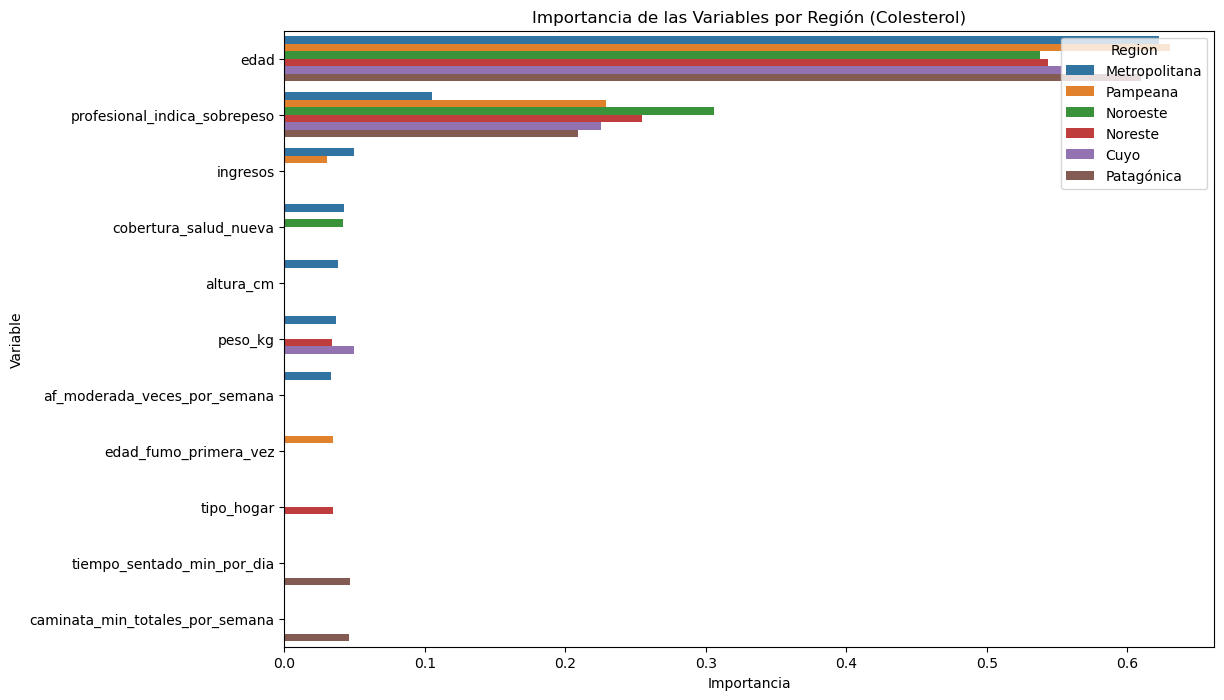

In [14]:

plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Variable', hue='Region', data=importancias_colesterol_df)
plt.title('Importancia de las Variables por Región (Colesterol)')
plt.show()

### Conclusiones: 

1. Se observa que de forma previsible la edad y el sobrepeso son factores importantes en cualquier región.
2. En la región PATAGÖNICA aparece com un factor importante la cantidad de minutos sentado y caminata. Se debe realizar un análisis en profundidad para determinar los valores en estas variables, pero considerando el clima un poco más hostil en esta región podría inferirse que hay diferencias importantes en este aspecto.
3. El ingreso parece ser una variables de gran importancia en el área metropolitana indicando que pueden haber diferencias significativas en este aspecto.
4. Tanto en el área Metropolitana como en el Noreste se observa que el tipo de cobertura de salud es significativo.

### CARACTERÍSTICAS MÁS IMPORTANTES EN LA DETERMINACIÓN DE LA HIPERTENSIÓN SEPARADAS POR REGIÓN

In [15]:

# Crear un DataFrame vacío para almacenar las importancias
importancias_hipertension_df = pd.DataFrame(columns=['Region', 'Variable', 'Importancia'])


for region, importancias in importancia_por_region.items():
    # Obtener la importancia de colesterol de la región actual
    importances_hip = importancias['hipertension']
    
    # Obtener el DataFrame de la región actual para obtener los nombres de las columnas
    df_region = dfs_por_region[region]
    X_region = df_region.iloc[:, 1:-3]
    columnas_originales = X_region.columns
    
    # Ordenar los índices de las importancias de mayor a menor
    indices_ordenados = np.argsort(importances_hip)[::-1]
    
    # Obtener el nombre de la región
    nombre_region = region_dict.get(region, f"Región {region}")
    
    # Imprimir los resultados
    print(f"Región: {nombre_region}")
    for i in indices_ordenados:
        if importances_hip[i] > 0.03:  # solo imprimo columnas con importancia mayor a 0
                    
            print(f"{columnas_originales[i]}: {importances_hip[i]:.4f}")
            
            importancias_hipertension_df = importancias_hipertension_df.append({
                'Region': nombre_region,
                'Variable': columnas_originales[i],
                'Importancia': importances_hip[i]     
            }, ignore_index=True)
            
    print("\n") 






Región: Metropolitana
edad: 0.6146
peso_kg: 0.1434
ingresos: 0.0557
tiempo_sentado_min_por_dia: 0.0450
profesional_indica_sobrepeso: 0.0436


Región: Pampeana
edad: 0.7530
profesional_indica_sobrepeso: 0.1298
peso_kg: 0.0571


Región: Noroeste
edad: 0.6827
profesional_indica_sobrepeso: 0.1438
familiares_directos_diabetes: 0.0383


Región: Noreste
edad: 0.6659
profesional_indica_sobrepeso: 0.1654
peso_kg: 0.0329
sexo: 0.0324


Región: Cuyo
edad: 0.6212
profesional_indica_sobrepeso: 0.1789
nivel_instruccion: 0.0328
peso_kg: 0.0304


Región: Patagónica
edad: 0.6162
peso_kg: 0.1111
profesional_indica_sobrepeso: 0.1061
nivel_instruccion: 0.0391




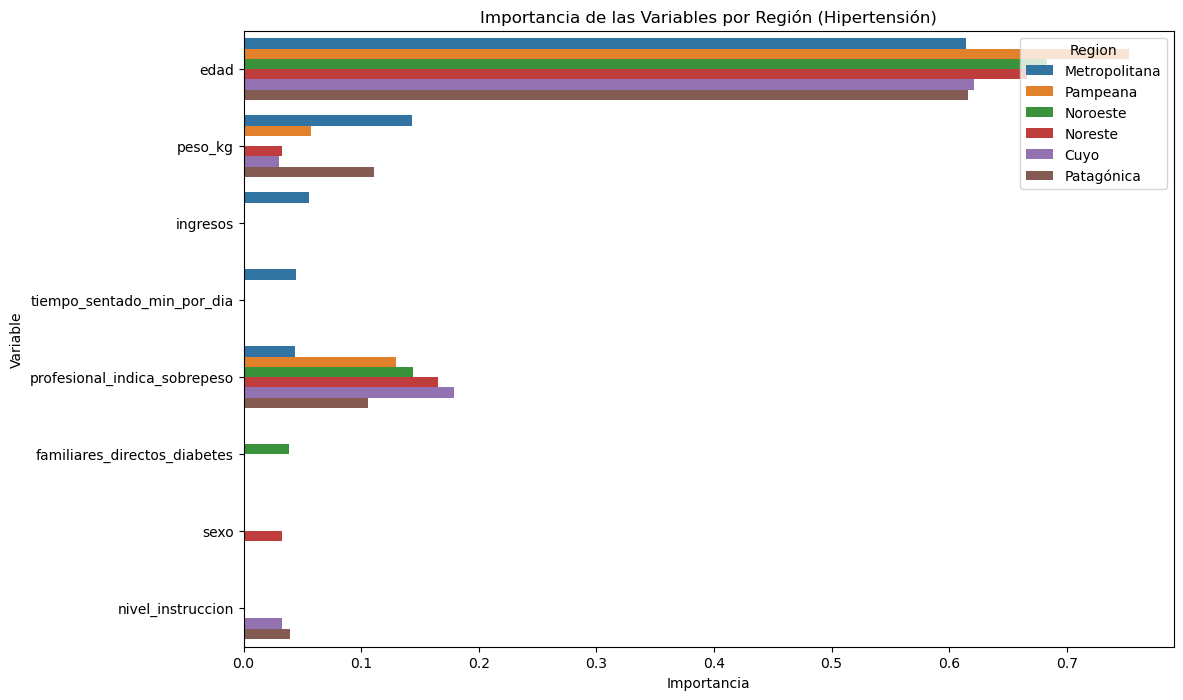

In [16]:

plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Variable', hue='Region', data=importancias_hipertension_df)
plt.title('Importancia de las Variables por Región (Hipertensión)')
plt.show()

### Conclusiones causas Hipertensión: 

1. Nuevamente se observa que la edad y el sobrepeso son variables importantes y generales en todas las regiones
2. En el Noroeste aparece como significativa la ocurrencia de familiares con diabetes en la determinación lo cual resulta llamativo ya que se está determinando la hipertensión. 
3. En el área Metropolitana, nuevamente el nivel de ingresos resultan significativos indicando diferencias importantes en este aspecto. Aparece también la cantidad de minutos sentado por día
4. Se observa en el Noreste una diferencia entre sexos
5. En cuyo y la patagonia el nivel de instrucción es significativo en la determinación de la hipertensión, tal vez por el tipo de trabajos u horas trabajadas, resposabilidades, etc.


### CARACTERÍSTICAS MÁS IMPORTANTES EN LA DETERMINACIÓN DE LA DIABETES SEPARADAS POR REGIÓN

In [17]:

# Crear un DataFrame vacío para almacenar las importancias
importancias_diabetes_df = pd.DataFrame(columns=['Region', 'Variable', 'Importancia'])

for region, importancias in importancia_por_region.items():
    # Obtener la importancia de colesterol de la región actual
    importances_dia = importancias['diabetes']
    
    # Obtener el DataFrame de la región actual para obtener los nombres de las columnas
    df_region = dfs_por_region[region]
    X_region = df_region.iloc[:, 1:-3]
    columnas_originales = X_region.columns
    
    # Ordenar los índices de las importancias de mayor a menor
    indices_ordenados = np.argsort(importances_dia)[::-1]
    
    # Obtener el nombre de la región
    nombre_region = region_dict.get(region, f"Región {region}")
    
   
    
    # Imprimir los resultados
    print(f"Región: {nombre_region}")
    for i in indices_ordenados:
        if importances_dia[i] > 0.05:  # solo imprimo columnas con importancia mayor a 0
            print(f"{columnas_originales[i]}: {importances_dia[i]:.4f}")
            
            importancias_diabetes_df = importancias_diabetes_df.append({
                'Region': nombre_region,
                'Variable': columnas_originales[i],
                'Importancia': importances_dia[i]     
            }, ignore_index=True)
    print("\n")


Región: Metropolitana
edad: 0.2823
familiares_directos_diabetes: 0.2326
peso_kg: 0.1405
familiares_no_directos_diabetes: 0.0903
tipo_hogar: 0.0768
nivel_instruccion: 0.0731


Región: Pampeana
profesional_indica_sobrepeso: 0.3493
edad: 0.2753
familiares_directos_diabetes: 0.2041
peso_kg: 0.0545


Región: Noroeste
profesional_indica_sobrepeso: 0.3433
edad: 0.2301
familiares_directos_diabetes: 0.2078
peso_kg: 0.0775


Región: Noreste
edad: 0.3363
familiares_directos_diabetes: 0.2816
af_moderada_min_totales_por_semana: 0.0806
peso_kg: 0.0521


Región: Cuyo
edad: 0.3387
profesional_indica_sobrepeso: 0.1862
familiares_directos_diabetes: 0.1405
peso_kg: 0.1313
nivel_actividad_fisica: 0.0671
cant_componentes: 0.0523


Región: Patagónica
edad: 0.2583
familiares_directos_diabetes: 0.1789
profesional_indica_sobrepeso: 0.1632
peso_kg: 0.1067
nivel_instruccion: 0.0727




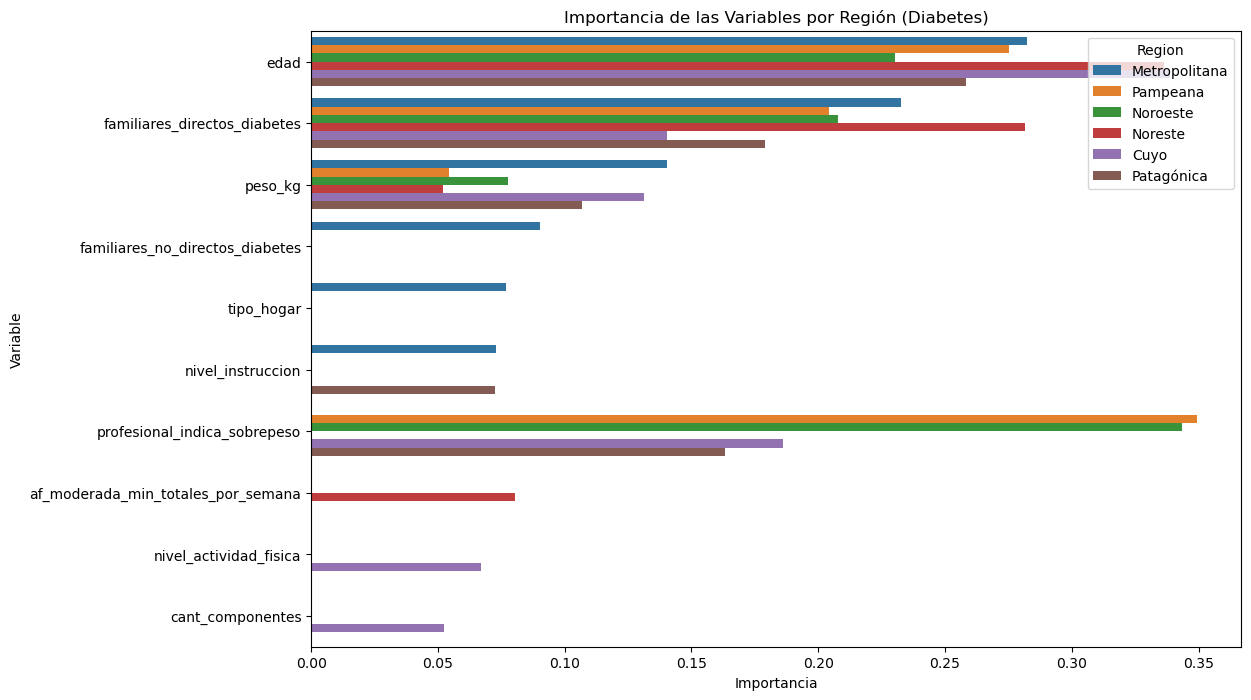

In [18]:

plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Variable', hue='Region', data=importancias_diabetes_df)
plt.title('Importancia de las Variables por Región (Diabetes)')
plt.show()

### Conclusiones causas Diabetes:

1. Se observan las variables edad y el peso como importantes en la mayoría de las regiones.
2. La variable familiares directos con diabetes resulta significativa en la mayoría de las regiones indicando que existe posiblemente un componente hereditario en la mayoría de los casos de diabetes.
3. En la región de cuyo es importante el nivel de actividad física y la cantidad de compoentes en la familia, similar al Noreste
4. En la regipon Metropolitana, el tiop de hogar parece ser significativo.

# OPTIMIZACIÓN DE HIPERPARÁMETROS PARA MEJORAR EL MODELO

Se optimizarán los hiperparámetros con el objetivo de buscar mejorar las métricas y que los modelos sean capaces de predecir mejor las enfermedades (especialmente la hipertensión y el colesterol que tuvieron los peores resultados) y de esta forma encontrar las causas reales (o corroborar que eran las mismas)

In [19]:
#importación librería

from sklearn.model_selection import GridSearchCV #para optimizar hiperparámetros

In [20]:

#definimos grilla de hiperparámetros


param_grid = {
    'criterion': ['gini', 'entropy'],   #funcion para medir la calidad de la division
    'splitter': ['best', 'random'],     #estratedia para dividir cada nodo
    'max_depth': [None, 10, 20, 30, 40, 50],    #profundidad máxima del arbol
    'min_samples_split': [2, 5, 10],      #numero minimo de muestras necesarias para dividir un nodo
    'min_samples_leaf': [1, 2, 4],         #numero minimo de muestras para estar en un nodo hoja
    'max_features': [None, 'sqrt', 'log2']   #numero de caracteristicas a considerar para buscar ña mejor division
}

    

In [21]:
# Crear diccionarios para almacenar modelos y resultados por región
modelos_por_region = {}
resultados_por_region = {}
importancia_por_region = {}



# Iterar sobre cada región para entrenar y evaluar modelos
for region in regiones:
    # Obtener el DataFrame de la región actual
    df_region = dfs_por_region[region]
    
    # Variables independientes
    X_region = df_region.iloc[:, 1:-3]  # Todas las columnas menos las últimas tres y la primera (id)
    
    # Variables dependientes
    y_region_colesterol = df_region['colesterol_alto']
    y_region_diabetes = df_region['dijeron_diabetes']
    y_region_hipertension = df_region['veces_presion_alta']

    # Dividir los datos en conjuntos de entrenamiento y prueba para cada enfermedad
    X_train_col, X_test_col, y_train_col, y_test_col = train_test_split(X_region, y_region_colesterol, test_size=0.25, random_state=0)
    X_train_dia, X_test_dia, y_train_dia, y_test_dia = train_test_split(X_region, y_region_diabetes, test_size=0.25, random_state=0)
    X_train_hip, X_test_hip, y_train_hip, y_test_hip = train_test_split(X_region, y_region_hipertension, test_size=0.25, random_state=0)
    
    # Crear y entrenar el modelo de árbol de decisión para cada enfermedad usando GRIDSEARCH
    clf_col = DecisionTreeClassifier(random_state=0)
    grid_search_col =  GridSearchCV(estimator=clf_col, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_search_col.fit(X_train_col, y_train_col)       # Ajustar GridSearchCV a los datos
    #print("Mejores hiperparámetros para colesterol: ", grid_search_col.best_params_)
    mejor_modelo_col = grid_search_col.best_estimator_    # Usar el mejor modelo encontrado para hacer predicciones
    
    
    clf_dia = DecisionTreeClassifier(random_state=0)
    grid_search_dia =  GridSearchCV(estimator=clf_dia, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_search_dia.fit(X_train_dia, y_train_dia)
    #print("Mejores hiperparámetros para Diabetes: ", grid_search_dia.best_params_)
    mejor_modelo_dia = grid_search_dia.best_estimator_
    
    
    clf_hip = DecisionTreeClassifier(random_state=0)
    grid_search_hip =  GridSearchCV(estimator=clf_hip, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_search_hip.fit(X_train_hip, y_train_hip)   
    #print("Mejores hiperparámetros para hipertensión: ", grid_search_hip.best_params_)
    mejor_modelo_hip = grid_search_hip.best_estimator_     
  
    # Almacenar los modelos y sus resultados por región
    modelos_por_region[region] = {
        'colesterol': mejor_modelo_col,
        'diabetes': mejor_modelo_dia,
        'hipertension': importances_hip
    }

         
    #importancia de cada columna en el modelo entrenado
    importances_col = mejor_modelo_col.feature_importances_
    importances_dia = mejor_modelo_dia.feature_importances_
    importances_hip = mejor_modelo_hip.feature_importances_
    
    importancia_por_region[region]={
        'colesterol': importances_col,
        'diabetes': importances_dia,
        'hipertension': importances_hip  
    }
      
        
    # Probar el mejor modelo encontrado con conjunto de prueba
    y_pred_col = mejor_modelo_col.predict(X_test_col)
    y_pred_dia = mejor_modelo_dia.predict(X_test_dia)
    y_pred_hip = mejor_modelo_hip.predict(X_test_hip)
  
    
    
    ## METRICAS DE EVALUACIÓN   ##############33
    metricas(y_pred_col, y_test_col, 'colesterol', region)
    metricas(y_pred_dia, y_test_dia, 'diabetes', region)
    metricas(y_pred_hip, y_test_hip, 'hipertension', region)

print('Finalizado')

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Fitting 3 folds for each of 648 candidat

In [22]:
# Mostrar los resultados por enfermedad y por región

for enfermedad, regiones in resultados_por_region.items():
    for region, resultados in regiones.items():

        nombre_region = resultados_por_region.get(region, f"Región {region}")
        print(f"Enfermedad: {enfermedad}")
        print(f"Región: {nombre_region}")
        print(f"Exactitud del modelo: {resultados['exactitud']:.4f}")
        print(f"Precision del modelo: {resultados['precision']:.4f}")
        print(f"Sensibilidad del modelo: {resultados['sensibilidad']:.4f}")
        print(f"f1 del modelo: {resultados['f1']:.4f}")
        print(f"Matriz de confusion del modelo: \n{resultados['confusion']}\n")

Enfermedad: colesterol
Región: Región 1
Exactitud del modelo: 0.7222
Precision del modelo: 0.6332
Sensibilidad del modelo: 0.7222
f1 del modelo: 0.6378
Matriz de confusion del modelo: 
[[ 11 204]
 [ 21 574]]

Enfermedad: colesterol
Región: Región 2
Exactitud del modelo: 0.7697
Precision del modelo: 0.6995
Sensibilidad del modelo: 0.7697
f1 del modelo: 0.7159
Matriz de confusion del modelo: 
[[  41  393]
 [  84 1553]]

Enfermedad: colesterol
Región: Región 3
Exactitud del modelo: 0.7708
Precision del modelo: 0.7051
Sensibilidad del modelo: 0.7708
f1 del modelo: 0.7197
Matriz de confusion del modelo: 
[[ 26 218]
 [ 49 872]]

Enfermedad: colesterol
Región: Región 4
Exactitud del modelo: 0.7932
Precision del modelo: 0.7379
Sensibilidad del modelo: 0.7932
f1 del modelo: 0.7479
Matriz de confusion del modelo: 
[[ 22 149]
 [ 33 676]]

Enfermedad: colesterol
Región: Región 5
Exactitud del modelo: 0.7233
Precision del modelo: 0.6708
Sensibilidad del modelo: 0.7233
f1 del modelo: 0.6721
Matriz d

## Conclusiones de la optimización

### <u>Respecto al Colesterol<u>
1. Se observa una mejora en la precisión, es decir que mejora la predicción de positivos. El resto de las métricas no varían considerablemente
2. Se obtienen algunos verdaderos negativos en la region 1, 2 y mejora la region 6
    
### <u>Respecto a la Diabetes<u>
1. Prácticamente todas las métricas se mantienen igual o levemente menor(con algunas diferencias del orden del 0.01 aproximadamente. 
2. Se observa una mejora en la región 6

### <u>Respecto a la Hipertensión<u>
1. Nuevamente no se observan mejoras considerables, en general las métricas empeoran levemente. 
    

## Parametros más importantes en el modelo con hiperparámetros mejorados para el colesterol

In [23]:

# Crear un DataFrame vacío para almacenar las importancias
importancias_colesterol_df_mejorado = pd.DataFrame(columns=['Region', 'Variable', 'Importancia'])


for region, importancias in importancia_por_region.items():
    # Obtener la importancia de colesterol de la región actual
    importances_col = importancias['colesterol']
    
    # Obtener el DataFrame de la región actual para obtener los nombres de las columnas
    df_region = dfs_por_region[region]
    X_region = df_region.iloc[:, 1:-3]
    columnas_originales = X_region.columns
    
    # Ordenar los índices de las importancias de mayor a menor
    indices_ordenados = np.argsort(importances_col)[::-1]
    
    # Obtener el nombre de la región
    nombre_region = region_dict.get(region, f"Región {region}")
    
    # Imprimir los resultados
    print(f"Región: {nombre_region}")
    for i in indices_ordenados:
        if importances_col[i] > 0.04:  # solo imprimo columnas con importancia mayor a 0
                                 
            print(f"{columnas_originales[i]}: {importances_col[i]:.4f}")
            
            importancias_colesterol_df_mejorado = importancias_colesterol_df_mejorado.append({
                'Region': nombre_region,
                'Variable': columnas_originales[i],
                'Importancia': importances_col[i]     
            }, ignore_index=True)
            
    print("\n")    
    

Región: Metropolitana
edad: 0.1557
profesional_indica_sobrepeso: 0.0870
sexo: 0.0642
peso_kg: 0.0545
obtiene_gas: 0.0524
tipo_hogar: 0.0441


Región: Pampeana
edad: 0.1578
profesional_indica_sobrepeso: 0.0933
actualmente_fuma_cigarrillos: 0.0626
tipo_hogar: 0.0426


Región: Noroeste
situacion_conyugal: 0.0987
edad: 0.0892
cobertura_salud_nueva: 0.0743
profesional_indica_sobrepeso: 0.0693
actualmente_fuma_cigarrillos: 0.0441
nivel_actividad_fisica: 0.0409


Región: Noreste
edad: 0.1682
situacion_conyugal: 0.0962
profesional_indica_sobrepeso: 0.0701
cobertura_salud_nueva: 0.0504
promedio_fv_diario: 0.0459
af_fue_actividad_laboral: 0.0424


Región: Cuyo
edad: 0.0772
ansiedad_depresion: 0.0595
cobertura_salud_nueva: 0.0571
tiempo_sentado_min_por_dia: 0.0494
familiares_no_directos_diabetes: 0.0469
nivel_instruccion: 0.0418


Región: Patagónica
profesional_indica_sobrepeso: 0.1254
edad: 0.0952
cant_componentes: 0.0766
cobertura_salud_nueva: 0.0711
situacion_conyugal: 0.0494
nivel_instruccion

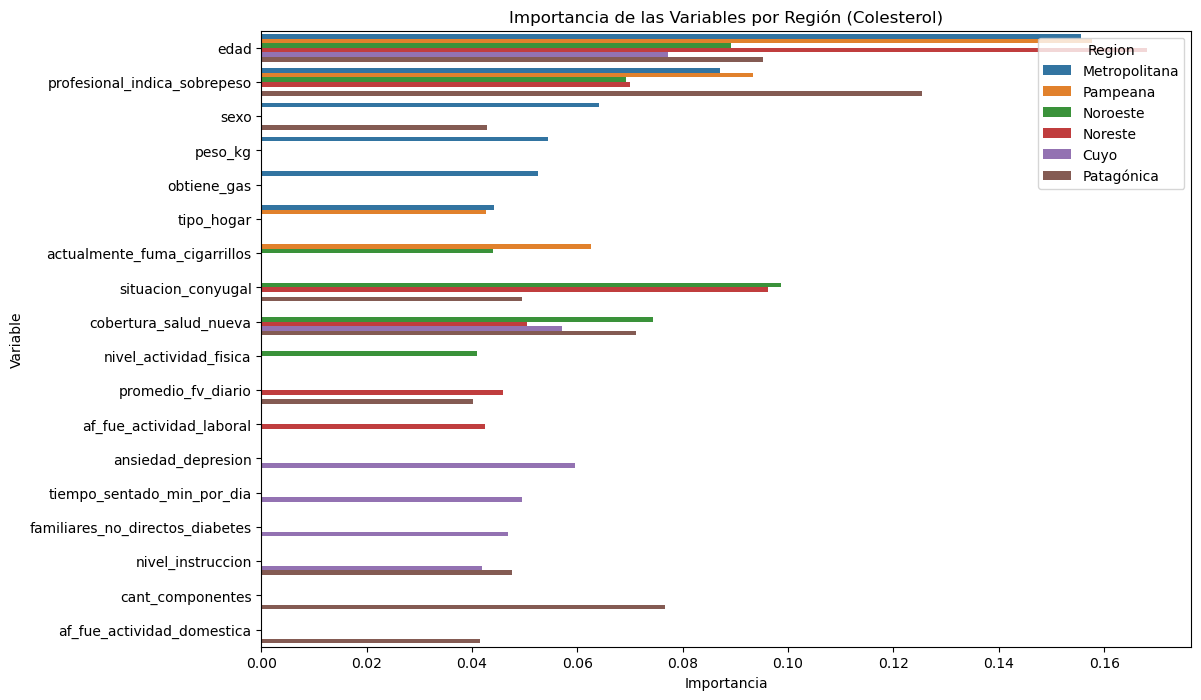

In [24]:

plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Variable', hue='Region', data=importancias_colesterol_df_mejorado)
plt.title('Importancia de las Variables por Región (Colesterol)')
plt.show()

### Conclusiones
1. Nuevamente aparecen la edad y el sobrepeso como causas más importantes
2. En la región pampeana y noroeste resulta importante la variable actualmente_fuma_cigarrillos
3. Aparece la variable ansiedad_depresion en la region de cuyo
4. En la regipon metropolitana aparece una distinción de acuerdo al sexo
5. La situación conyugal es significativa en el noroeaste y el noreste


## Parametros más importantes en el modelo con hiperparámetros mejorados para la hipertensión


In [25]:

# Crear un DataFrame vacío para almacenar las importancias
importancias_hipertension_df_mejorado = pd.DataFrame(columns=['Region', 'Variable', 'Importancia'])


for region, importancias in importancia_por_region.items():
    # Obtener la importancia de colesterol de la región actual
    importances_hip = importancias['hipertension']
    
    # Obtener el DataFrame de la región actual para obtener los nombres de las columnas
    df_region = dfs_por_region[region]
    X_region = df_region.iloc[:, 1:-3]
    columnas_originales = X_region.columns
    
    # Ordenar los índices de las importancias de mayor a menor
    indices_ordenados = np.argsort(importances_hip)[::-1]
    
    # Obtener el nombre de la región
    nombre_region = region_dict.get(region, f"Región {region}")
    
    # Imprimir los resultados
    print(f"Región: {nombre_region}")
    for i in indices_ordenados:
        if importances_hip[i] > 0.04:  # solo imprimo columnas con importancia mayor a 0
                    
            print(f"{columnas_originales[i]}: {importances_hip[i]:.4f}")
            
            importancias_hipertension_df_mejorado = importancias_hipertension_df_mejorado.append({
                'Region': nombre_region,
                'Variable': columnas_originales[i],
                'Importancia': importances_hip[i]     
            }, ignore_index=True)
            
    print("\n") 



Región: Metropolitana
edad: 0.1290
nivel_actividad_fisica: 0.0650
nivel_instruccion: 0.0530
peso_kg: 0.0495
actualmente_fuma_cigarrillos: 0.0488
situacion_conyugal: 0.0487
cobertura_salud_nueva: 0.0465


Región: Pampeana
edad: 0.3106
peso_kg: 0.0929
ingresos: 0.0675
altura_cm: 0.0654
profesional_indica_sobrepeso: 0.0490
promedio_fv_diario: 0.0481


Región: Noroeste
situacion_conyugal: 0.0825
peso_kg: 0.0633
edad: 0.0603
af_intensa_min_totales_por_semana: 0.0507
nivel_instruccion: 0.0484
profesional_indica_sobrepeso: 0.0463
nivel_actividad_fisica: 0.0409


Región: Noreste
edad: 0.3003
profesional_indica_sobrepeso: 0.0770


Región: Cuyo
edad: 0.1114
profesional_indica_sobrepeso: 0.1011
actualmente_fuma_cigarrillos: 0.0672
nivel_actividad_fisica: 0.0541


Región: Patagónica
edad: 0.2172
peso_kg: 0.0796
nivel_instruccion: 0.0479
considera_su_alimentacion: 0.0407
promedio_fv_diario: 0.0401




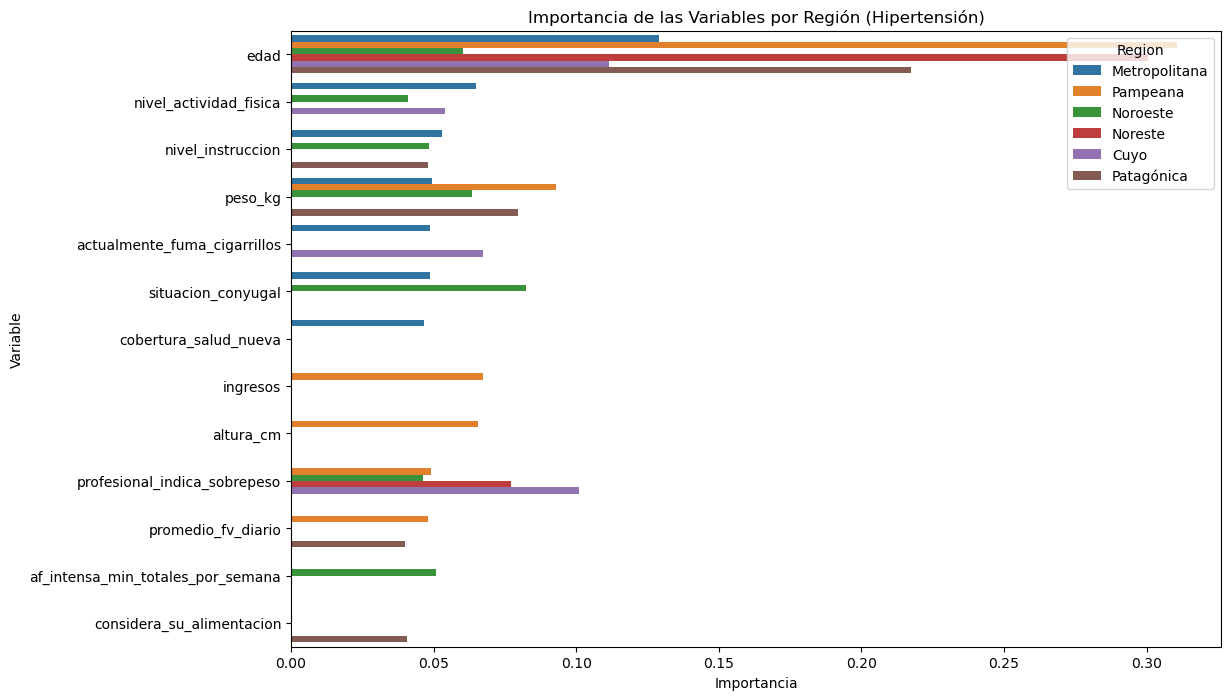

In [26]:

plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Variable', hue='Region', data=importancias_hipertension_df_mejorado)
plt.title('Importancia de las Variables por Región (Hipertensión)')
plt.show()

### Conclusiones
1. Se repiten como más importantes las características de edad y sobrepeso (o la variable peso) en la mayoría de las regiones 
2. El tipo de alimentación es importante en la regipon patagónica
3. EN la región metropolitana y cuyo aparece la variable fuma_Actualmente_cigarrillos
4. El nivel de ingresos es significativo en la regipon pampeana

## Parametros más importantes en el modelo con hiperparámetros mejorados para la diabetes

In [27]:

# Crear un DataFrame vacío para almacenar las importancias
importancias_diabetes_df_mejorado = pd.DataFrame(columns=['Region', 'Variable', 'Importancia'])

for region, importancias in importancia_por_region.items():
    # Obtener la importancia de diabetes de la región actual
    importances_dia = importancias['diabetes']
    
    # Obtener el DataFrame de la región actual para obtener los nombres de las columnas
    df_region = dfs_por_region[region]
    X_region = df_region.iloc[:, 1:-3]
    columnas_originales = X_region.columns
    
    # Ordenar los índices de las importancias de mayor a menor
    indices_ordenados = np.argsort(importances_dia)[::-1]
    
    # Obtener el nombre de la región
    nombre_region = region_dict.get(region, f"Región {region}")
    
   
    
    # Imprimir los resultados
    print(f"Región: {nombre_region}")
    for i in indices_ordenados:
        if importances_dia[i] > 0.05:  # solo imprimo columnas con importancia mayor a 0
            print(f"{columnas_originales[i]}: {importances_dia[i]:.4f}")
            
            importancias_diabetes_df_mejorado = importancias_diabetes_df_mejorado.append({
                'Region': nombre_region,
                'Variable': columnas_originales[i],
                'Importancia': importances_dia[i]     
            }, ignore_index=True)
    print("\n")


Región: Metropolitana
edad: 0.0973
familiares_no_directos_diabetes: 0.0895
tipo_vivienda: 0.0720
profesional_indica_sobrepeso: 0.0547


Región: Pampeana
edad: 0.1420
profesional_indica_sobrepeso: 0.1157
peso_kg: 0.0707


Región: Noroeste
familiares_directos_diabetes: 0.0706
nivel_actividad_fisica: 0.0638
situacion_conyugal: 0.0574


Región: Noreste
familiares_no_directos_diabetes: 0.0796
profesional_indica_sobrepeso: 0.0558
nivel_instruccion: 0.0552
tipo_hogar: 0.0517


Región: Cuyo
nivel_actividad_fisica: 0.0689
profesional_indica_sobrepeso: 0.0631
edad: 0.0570
af_intensa_min_totales_por_semana: 0.0520


Región: Patagónica
edad: 0.0824
nivel_actividad_fisica: 0.0764
situacion_conyugal: 0.0654
actualmente_fuma_cigarrillos: 0.0620
familiares_no_directos_diabetes: 0.0607
consumido_alcohol: 0.0535




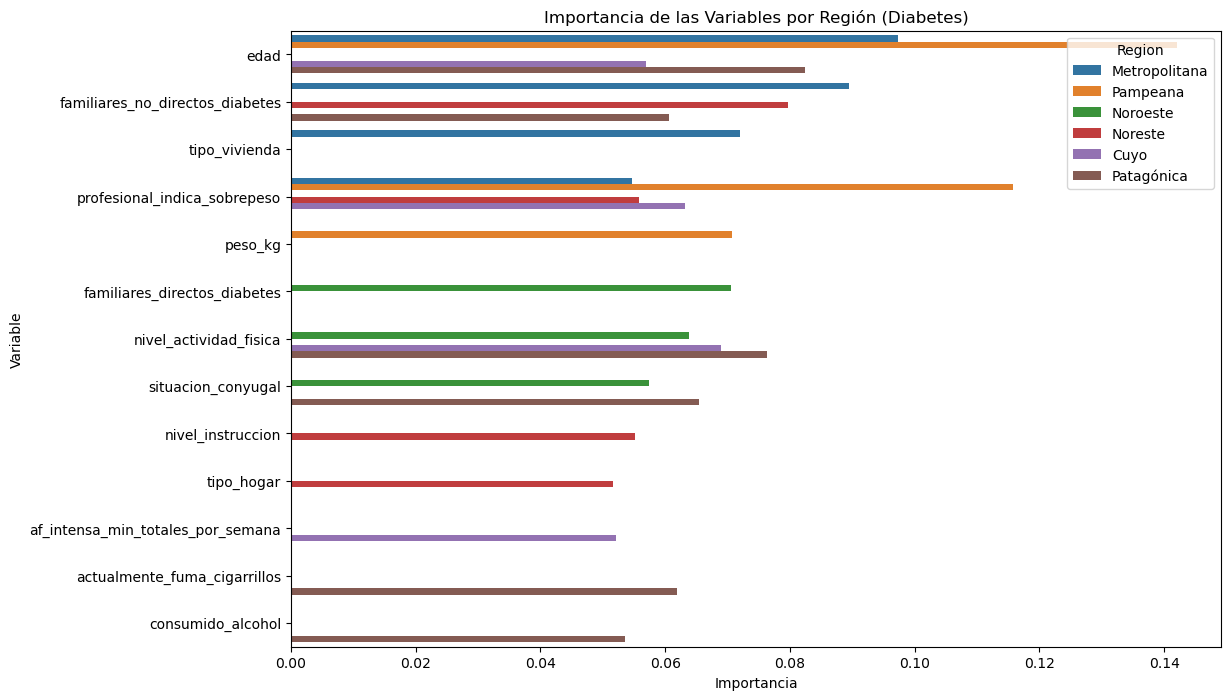

In [28]:


plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Variable', hue='Region', data=importancias_diabetes_df_mejorado)
plt.title('Importancia de las Variables por Región (Diabetes)')
plt.show()

### Conclusiones
1. La variable edad desaparece en los valores mas significativos de las regiones NORESTE y NOROESTE
2. EL alcohol y cigarrillos aparecen en la regipon patagónica
3. La actividad física intensa en significativo en cuyo
4. Familiares directos con diabetes solo aparece en el NOROESTE y si aparece en otras regiones la variable familiares no directos con diabetes
5. El nivel de instrucción y tipo de hogar son significativos en el NORESTE


# CONCLUSIONES GENERALES

Se evaluará otro algoritmo que no sea arboles de decisión para el ajuste